# 0. 환경설정

In [ ]:
import os
import logging
from dotenv import load_dotenv
from typing import Literal, TypedDict, List
from pydantic import BaseModel, Field
from langchain.schema import Document
from langchain_community.retrievers import BM25Retriever
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings

from langchain_core.documents import Document
from langchain.retrievers import BM25Retriever, EnsembleRetriever
import ast

In [ ]:
#----1. 모델 정의----

load_dotenv()
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

model = AzureChatOpenAI(
    model="gpt-4o",
    #temperature=0
)

In [18]:
#----2. State 정의----
class State(TypedDict):
    # 초기 입력
    original_content: str
    selected_mood: str 
    datetime: str
    
    # RAG 결과물
    content_format: str
    retrieved_format_guide: List[Document] # 변환 예시 검색 결과
    format_revised_content: str # 변환된 글
    
    #검증
    validation_result: str 
    
    # 최종 결과물
    metadata: dict # 태그, 주제 등
    validation_error: str
    final_json: dict

In [ ]:
#----3. RAG 설정----

# Chroma DB 경로
persist_directory = "./chroma_db"

docs = []
data_folder = './format_guide'

for file_name in os.listdir(data_folder):
    if not file_name.lower().endswith(('.txt')):
        continue

    file_path = os.path.join(data_folder, file_name)
    
    # 파일을 utf-8 인코딩으로 엽니다.
    with open(file_path, 'r', encoding='utf-8') as f:
        # 첫 줄을 읽어 메타데이터로 사용
        metadata_line = f.readline().strip()
        
        # 나머지 내용을 모두 읽어 page_content로 사용
        page_content = f.read().strip()

        # 메타데이터 문자열을 파이썬 딕셔너리로 안전하게 변환
        metadata = ast.literal_eval(metadata_line)
        
        # page_content가 비어있지 않은 경우에만 문서를 추가합니다.
        if page_content:
            # Document 객체 생성 및 리스트에 추가
            docs.append(Document(page_content=page_content, metadata=metadata))

print(f"총 {len(docs)}개의 문서를 로드했습니다.")


# Chroma DB 존재 여부 확인 및 처리 
if os.path.exists(persist_directory) and len(os.listdir(persist_directory)) > 0:
    print("기존 Chroma DB 로드")
    chroma_db = Chroma(
        persist_directory=persist_directory,
        embedding_function=AzureOpenAIEmbeddings(model="text-embedding-3-small")
    )
else:
    # docs 리스트가 비어있지 않은 경우에만 DB 생성
    if docs:
        print("새로운 Chroma DB 생성 및 저장")
        embeddings = AzureOpenAIEmbeddings(
            model="text-embedding-3-small"
        )
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
        split_docs = text_splitter.split_documents(docs)
        print(f"청크 후 문서 개수: {len(split_docs)}")
        
        valid_docs = [doc for doc in split_docs if doc.page_content.strip()]
        if len(valid_docs) < len(split_docs):
            print(f"비어있는 문서 {len(split_docs) - len(valid_docs)}개를 제외했습니다.")

        chroma_db = Chroma.from_documents(
            documents=split_docs,
            embedding=embeddings,
            persist_directory=persist_directory
        )
    else:
        print("로드된 문서가 없어 DB를 생성하지 않습니다.")

# docs 리스트가 비어있지 않은 경우에만 Retriever 설정
if docs:
    chroma_retriever = chroma_db.as_retriever(search_kwargs={"k": 10})
    bm25_retriever = BM25Retriever.from_documents(docs)
    ensemble_retriever = EnsembleRetriever(
        retrievers=[chroma_retriever, bm25_retriever],
        weights=[0.5, 0.5]
    )
    print("RAG 설정 완료.")

총 40개의 문서를 로드했습니다.
기존 Chroma DB 로드
RAG 설정 완료.


In [ ]:
#---- Node 설정----

def router(state: State) -> State:
    return state

class RouteQuery(BaseModel):
    router: Literal["emotional", "organizational", "reflective", "analytical", "random"] = Field(description="Given a user question choose to route it to emotional, organizational, reflective, analytical and random.")

def route_query(state: State) -> Literal["emotional", "organizational", "reflective", "analytical", "random"]:
    """사용자 질문 라우팅"""
    model_with_structured_output = model.with_structured_output(RouteQuery)
    original_content = state["original_content"]
    
    system = """
    You are an expert at routing/classifying a user question to emotional, organizational, reflective, analytical and random.
    
    Classification Criteria:
    1. emotional: 
        - 설명: 오늘 있었던 사건 + 감정 서술, 감정이 생생하게 표현됨
        - 예시 표현: “너무 좋았다”, “설렜다”, “긴장됐다”, “ㅠㅠㅠ”, “오늘 아침에~”, “학교 갔는데~”
        - 특징/목적: 감정의 해소, 오늘 느낀 일 기록
        - 예시: 아침부터 기분이 너무 좋았다. 엄마가 해준 카레가 유난히 맛있었고, 덕분에 하루가 잘 풀릴 것 같은 기분이었다. 학교에 가는 발걸음도 가벼웠는데, 거기서 그 오빠를 마주쳤다.나한테 웃으면서 인사해주는데… 솔직히 말하면 그 순간 심장이 덜컥했다.근데 문제는 그 뒤부터다.점심도 같이 먹었는데, 결국 강의 얘기나 하다 끝나버렸다.나는 왜 그 사람 앞에만 가면 말을 제대로 못할까? 오히려 일부러 차갑게 말하게 되는 것도 같다.혹시 내가 좋아하는 걸 눈치 챘을까?그런 생각하니까 더 복잡해진다.오늘은 이 생각들 그냥 품고 자야겠다.
    2. organizational:
        - 설명: 구체적인 사건 없이 감정/생각 흐름 정리, 구조는 있으나 결론은 열려 있음
        - 예시 표현: “요즘 자꾸 ~ 생각이 든다”, “이유는 잘 모르겠지만”, “그러다 문득”
        - 특징/목적: 마음 정리, 두서 없는 생각을 붙잡기
        - 예시: 좋아하는 사람 앞에서는 왜 이렇게 말이 안 나올까. 평소엔 잘 웃고 말도 하는 편인데, 유독 그 사람 앞에선 엉망이 된다. 오늘도 점심 같이 먹으면서 무슨 말을 해야 할지 몰라서, 결국 강의 이야기 몇 마디 하다 끝났다. 일부러 차갑게 말하는 척하는 나 자신도 웃기고, 그 사람이 혹시 다 알고 있는 건 아닐까 걱정되는 마음도 크다. 좋아하는 마음을 들키는 게 두려운 건지, 아니면 들켰을 때 아무 일도 안 생기는 게 무서운 건지 나도 잘 모르겠다.
    3. reflective: 
        - 설명: 지나간 사건을 되돌아보며 자기 분석, 스스로에 대한 인식/성찰 포함
        - 예시 표현: “나는 항상 ~ 하는 사람이다”, “예전엔 몰랐다”, “지금 돌아보면”
        - 특징/목적: 성찰/후회/깨달음에 대한 자각
        - 예시: 나는 항상 중요한 순간에 어색해진다.ㅡ누가 날 좋아하길 바라고, 다가와주길 바라면서도 정작 그런 순간이 오면 한 발짝 뒤로 물러서버린다. 오늘 점심처럼.그 사람이 옆에 있었고, 나도 그 시간이 좋았는데말은 제대로 못 했다. 오히려 차갑게 굴고, 멀어진 느낌만 남았다. 이런 패턴을 반복하면서도,그 순간엔 그걸 멈추기가 참 어렵다. 아마 나는 아직 누군가를 진짜 좋아하고 그 감정을 있는 그대로 꺼내놓는 게 서툰 사람인 것 같다.
    4. analytical
        - 설명: 사실/지식/현상 설명 + 내 생각 추가, 감정보다는 관찰/분석 위주
        - 예시 표현: “이건 심리학적으로 보면~”, “사람들은 보통 하지만 나는~”
        - 특징/목적: 정보를 전달하면서 주관적 해석
        - 예시: 좋아하는 사람 앞에서 말이 꼬이고 긴장되는 현상은 꽤 일반적인 심리 반응이다. 특히 감정적으로 민감한 관계일수록 뇌가 스트레스를 인지하고 과잉반응하는 경향이 있다. 나 역시 그랬다. 평소엔 잘 말하다가도 그 사람 앞에만 가면 긴장해서 어색해진다. 심지어 일부러 무뚝뚝하게 구는 자신을 보면서, “왜 이렇게 굴까?” 하는 생각도 들었다. 결국 이건 감정을 표현하는 데 있어서의 불안과 두려움, 그리고 예상되는 거절에 대한 자기방어일 수 있다. 인지하고 나니 조금은 편해졌다. 완벽하게 말하지 않아도 괜찮다고, 관계는 한 번의 말보단 쌓이는 시간이라고 생각해보려 한다.
    5. random: 
        - 설명: 논리 없이 감정/생각/관찰이 나열됨, 대화체/메모 형식 자주 사용
        - 예시 표현: “아 맞다 근데”, “아무튼”, “몰라 그냥”, “생각해보니까?”, “ㅋㅋㅋ”
        - 특징/목적: 무의식 흐름에 따라 솔직한 표현
        - 예시:
            - 오늘 카레 진짜 맛있었음. 엄마 고마워.
            - 근데 그 오빠 웃으면서 인사했을 때 심장 멈추는 줄. 무슨 일이냐 진짜
            - 나 왜 이렇게 말 못하지? 아니 진짜.. 점심 내내 강의 얘기만 하다 끝남;;
            - 오히려 차갑게 말하는 척하는 내가 더 싫음
            - 오빠가 눈치 챘을까? 설마..?
            - 아 모르겠다 그냥 자야겠다. 꿈에서는 말 잘하자 나 자신아

    You must answer only one of these five words.
    """
    
    prompt_router = ChatPromptTemplate.from_messages(
        [
            ("system", system), 
            ("human", "{msg}")
        ]
    )
    
    chain_router = prompt_router | model_with_structured_output
    
    out = chain_router.invoke({"msg": original_content})
    
    if out.router == "emotional":
        route = "emotional"
    elif out.router == "organizational":
        route = "organizational"
    elif out.router == "reflective":
        route = "reflective"
    elif out.router == "analytical":
        route = "analytical"
    elif out.router == "random":
        route = "random"
    
    print(f">> ROUTE QUESTION TO {route.upper()}")
    state["content_format"] = route
    return state 


def node_retriever_format(state: State) -> State:
    """형식에 맞는 글 변환 예시 가져오기"""
    print(">> 1st RETRIEVE")
    format = state["content_format"]

    format_guide = ensemble_retriever.invoke(format)
    
    state["retrieved_format_guide"] = format_guide
    return state
    
    
def node_format_generation(state: State) -> State:
    """글 형식과 검색한 예시로 1차 글 변환"""
    print(">> 1st GENERATE")
    
    original_content = state["original_content"]
    format = state["content_format"]
    format_guide = state["retrieved_format_guide"]
    
    system = f""" 
    당신은 주어진 형식과 형식 예시에 맞게 사용자의 글을 변환하는 유능한 변환가입니다. 
    글의 형식은 {format}입니다. 
    다음 규칙에 따르세요. 형식 예시를 참고하여 오로지 사용자의 글을 형식에 맞게 반환해야 합니다. 
    
    규칙
    - 작성된 글이 형식과 비슷하다면 수정하지 마세요. 
    - 작성자의 말투와 종결어미는 동일하게 유지하세요. 
    
    글만 반환합니다. 
    """
    
    prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{msg}")])
    chain = prompt | model | StrOutputParser()
    
    out = chain.invoke({"format": format_guide, "msg": original_content})
    state["format_revised_content"] = out
    
    return state


class Metadata(BaseModel):
    topic: str = Field(description="글의 내용을 대표하는 창의적인 제목 (5~10 단어 내외)")
    emotion_tag: str = Field(description="글에 드러난 가장 핵심적인 감정 하나 (예: 기쁨, 슬픔, 분노, 평온, 설렘, 불안)")
    archive_tags: List[str] = Field(description="글의 핵심 주제를 나타내는 키워드 3~5개")


def node_metadata_extract(state: State) -> State:
    """글의 메타데이터 생성"""
    print(">> METADATA")
    
    original_content = state["original_content"]
    
    model_metadata_extractor = model.with_structured_output(Metadata)
    
    system = """
    You are a professional archivist who analyzes a diary entry and extracts key metadata.
    Based on the user's content, extract the topic, a single dominant emotion tag, and 3-5 archive tags for categorization.
    Please provide the output ONLY in the requested JSON format. Do not add any other explanatory text.
    """
    
    prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{msg}")])
    chain = prompt | model_metadata_extractor
    
    out = chain.invoke({"msg": original_content})
    state["metadata"] =  out.model_dump()
    return state


def node_assemble_json(state: State) -> State:
    """생성된 정보 전부 모아 JSON 형식으로 변환"""
    print(">> ASSEMBLE JSON ")
    
    metadata = state["metadata"]
    
    final_json = {
        "original_content": state["original_content"],
        "revised_content": state["format_revised_content"],
        "content_format": state["content_format"],
        "emotion_tag": metadata.get("emotion_tag"),
        "emotion_vector": [], #todo: 감정 태그나 글 내용으로 임베딩 벡터 생성
        "constellation_tag": "...", #todo: 별자리 태그 생성 로직
        "archive_tags": metadata.get("archive_tags"),
        "topic": metadata.get("topic")
    }
    
    state["final_json"] = final_json
    return state


class Proximity(BaseModel):
    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

    """
    def node_validate_generation(state: State) -> Literal["FALSE", "TRUE"]:
        """'생성된 내용과 원본 내용의 맥락이 동일한지 검증'"""
        print(">> CHECK GENERATION")
        
        original_content = state["original_content"]
        format_revised_content = state['format_revised_content']
        format = state["content_format"]
        format_guide = state["retrieved_format_guide"]
        

        system =
        You are a judge assessing if an LLM's generation is similar with the original text from user.
        The generation must include the context of the original text or must follow the main stream of the original text.
        It has been modified with the format: {format} with these guides and examples: {format_guide}.
        Give a binary score 'yes' or 'no'. 'Yes' means the generation is consistent with or meaningly follows from the provided guide.

        
        prompt_proximity_judge = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                ("human", "Original text: \n\n {original} \n\n LLM generation: {generation}")
            ]
        )
        
        model_with_structured_output = model.with_structured_output(Proximity)
        
        chain_hallucination = prompt_proximity_judge | model_with_structured_output
        
        out = chain_hallucination.invoke({"original": original_content, "generation": format_revised_content, 
                                        "format": format, "format_guide": format_guide})
        
        if out.binary_score == "yes":
            print("    >> DECISION: TRUE")
            state["validation_result"] = "TRUE"
        else:
            print("    >> DECISION: FALSE")
            state["validation_result"] = "FALSE"
        return state
        """

def node_validate_output(state: State) -> Literal["FALSE", "TRUE"]:
    """최종 JSON 결과물의 유효성을 검사하고 다음 단계 결정"""
    print(">> VALIDATE OUTPUT")
    
    final_json = state["final_json"]
    
    # 키 확인
    required_keys = ["topic", "emotion_tag", "archive_tags"]
    for key in required_keys:
        if not final_json.get(key):
            print(f">> VALIDATION FAILED: Missing or empty value for key '{key}'")
            state["validation_error"] = f"Key '{key}' is missing or empty."
            state["validation_result"] = "FALSE"
        else:
            state["validation_result"] = "TRUE"
    return state

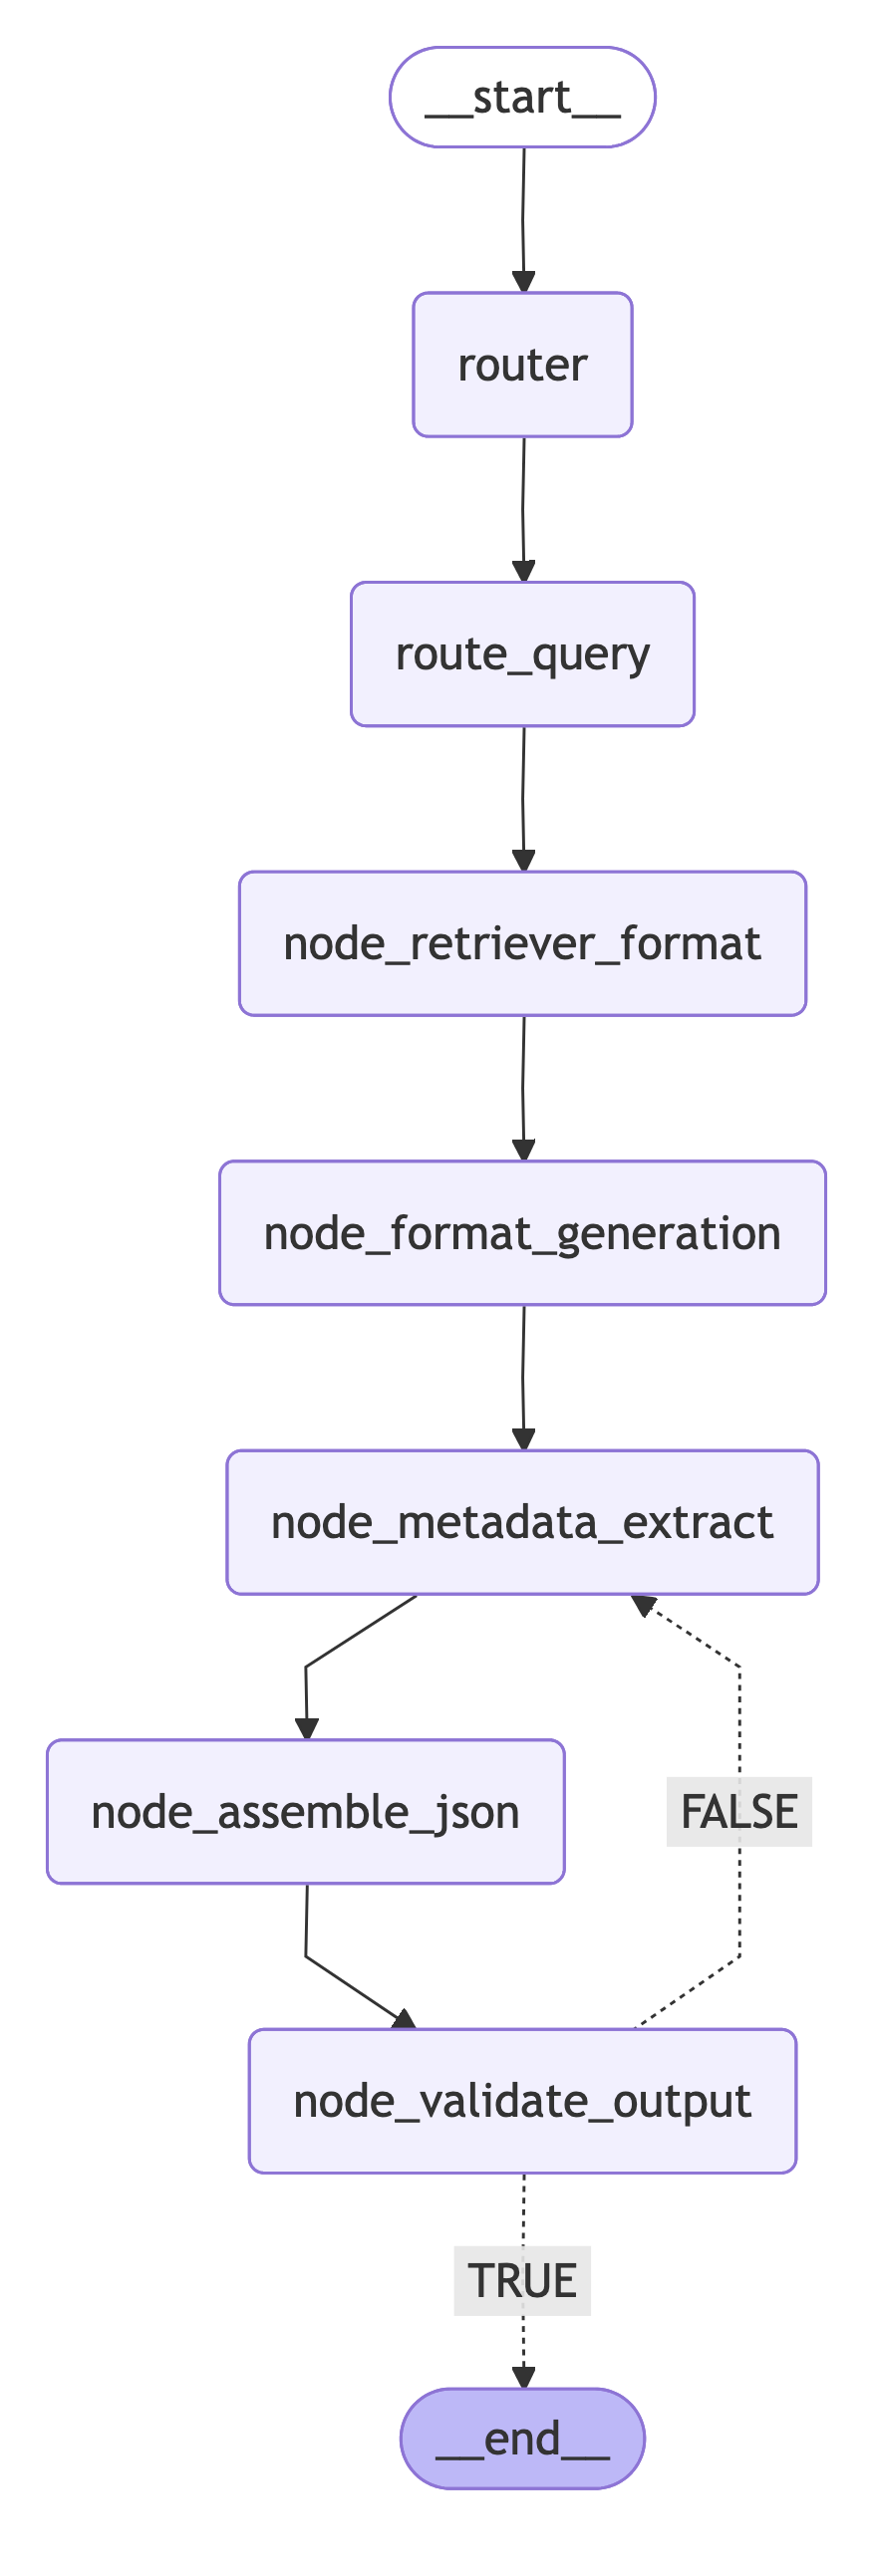

In [ ]:
#----7. 그래프 생성 및 컴파일----
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
import nest_asyncio

nest_asyncio.apply()
memory = MemorySaver()

graph = (
    StateGraph(State)
    .add_node("router", router)
    .add_node("route_query", route_query)
    .add_node("node_retriever_format", node_retriever_format)
    .add_node("node_format_generation", node_format_generation)
    .add_node("node_metadata_extract", node_metadata_extract)
    .add_node("node_assemble_json", node_assemble_json)
    .add_node("node_validate_output", node_validate_output)

    .add_edge(START, "router")
    .add_edge("router", "route_query")
    .add_edge("route_query", "node_retriever_format")
    .add_edge("node_retriever_format", "node_format_generation")
    .add_edge("node_format_generation", "node_metadata_extract")
    .add_edge("node_metadata_extract", "node_assemble_json")
    .add_edge("node_assemble_json", "node_validate_output")
    .add_conditional_edges(
        "node_validate_output",
        lambda state: state["validation_result"],  
        {
            "TRUE": END,
            "FALSE": "node_metadata_extract",
        }
    )
    .compile(checkpointer=memory)
)

#그래프 시각화
from IPython.display import display, Image

diagram = Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))
display(diagram)

In [ ]:
#----8. Test----

def run(input_msg: str, datetime_str: str):
    def clean(text):
        if not isinstance(text, str):
            text = str(text)
        return text.replace("\n", "")[:50] + "..."

    # LangGraph 실행 설정
    config = {
        "recursion_limit": 20,
        "configurable": {
            "thread_id": datetime_str,
        },
    }

    # 입력 설정
    inputs = {
        "original_content": input_msg,
        "datetime": datetime_str,
    }
    
    try:    
        final_state = {}
        for output in graph.stream(inputs, config=config): 
            for node_name, state_update in output.items():
                print(f"--- Node: {node_name} ---")
                final_state.update(state_update)

                if "original_content" in state_update:
                    print(f"     original_content    : {state_update['original_content']}")
                if "content_format" in state_update:
                    print(f"     content_format    : {state_update['content_format']}")
                if "retrieved_format_guide" in state_update:
                    for idx, doc in enumerate(state_update['retrieved_format_guide']):
                        print(f"     retrieved_format_guide    : {clean(doc.page_content)}")
                if "format_revised_content" in state_update:
                    print(f"     format_revised_content     : {state_update['format_revised_content']}")
                if "metadata" in state_update:
                    print(f"     metadata : {state_update['metadata']}")

        print("\n" + "="*50)
        print("Final Generation (JSON):")
        print(final_state.get("final_json"))
        print("="*50, "\n")
        
    except Exception as e:
        print(f"\n[ERROR] An unexpected error occurred: {e}")

In [23]:
#----9. Main 실행 블록----
import random
import datetime

if __name__ == "__main__":
    inputs = [
        "아침부터 기분이 너무 좋았다. 엄마가 해준 카레가 유난히 맛있었고, 덕분에 하루가 잘 풀릴 것 같은 기분이었다. 학교에 가는 발걸음도 가벼웠는데, 거기서 그 오빠를 마주쳤다. 나한테 웃으면서 인사해 주는데… 솔직히 말하면 그 순간 심장이 덜컥했다. 근데 문제는 그 뒤부터다. 점심도 같이 먹었는데, 결국 강의 얘기나 하다 끝나버렸다. 나는 왜 그 사람 앞에만 가면 말을 제대로 못할까? 오히려 일부러 차갑게 말하게 되는 것도 같다. 혹시 내가 좋아하는 걸 눈치 챘을까? 그런 생각하니까 더 복잡해진다. 오늘은 이 생각들 그냥 품고 자야겠다.",
        "좋아하는 사람 앞에서는 왜 이렇게 말이 안 나올까. 평소엔 잘 웃고 말도 하는 편인데, 유독 그 사람 앞에선 억양이 된다. \n 오늘도 점심 같이 먹으면서 무슨 말을 해야 할지 몰라서, 결국 강의 이야기 몇 마디 하다 끝났다. \n 일부러 차갑게 말하는 척하는 나 자신도 웃기고, 그 사람이 혹시 다 알고 있는 건 아닐까 걱정되는 마음도 크다. \n 좋아하는 마음을 들키는 게 두려운 건지, 아니면 들켰을 때 아무 일도 안 생기는 게 무서운 건지 나도 잘 모르겠다.",
        "나는 항상 중요한 순간에 어색해진다. 누가 날 좋아하길 바라고, 다가와주길 바라면서도 정작 그런 순간이 오면 한 발짝 뒤로 물러서 버린다. 오늘 점심처럼. 그 사람이 옆에 있었고, 나도 그 시간이 좋았는데 말은 제대로 못 했다. 오히려 차갑게 굴고, 멀어진 느낌만 남았다. 이런 패턴을 반복하면서도, 그 순간엔 그걸 멈추기가 참 어렵다. 아마 나는 아직 누군가를 진짜 좋아하고 그 감정을 있는 그대로 꺼내놓는 게 서툰 사람인 것 같다.",
        "좋아하는 사람 앞에서 말이 꼬이고 긴장되는 현상은 꽤 일반적인 심리 반응이다. 특히 감정적으로 민감한 관계일수록 뇌가 스트레스를 인지하고 과잉반응하는 경향이 있다. 나 역시 그랬다. 평소엔 잘 말하다가도 그 사람 앞에만 가면 긴장해서 어색해진다. 심지어 일부러 무뚝뚝하게 구는 자신을 보면서, “왜 이렇게 굴까?” 하는 생각도 들었다. 결국 이건 감정을 표현하는 데 있어서의 불안과 두려움,그리고 예상되는 거절에 대한 자기방어일 수 있다. 인지하고 나니 조금은 편해졌다. 완벽하게 말하지 않아도 괜찮다고, 관계는 한 번의 말보단 쌓이는 시간이라고 생각해보려 한다.",
        "o	오늘 카레 진짜 맛있었음. 엄마 고마워. \n o	근데 그 오빠 웃으면서 인사했을 때 심장 멈추는 줄. 무슨 일이냐 진짜 \n o	나 왜 이렇게 말 못하지? 아니 진짜.. 점심 내내 강의 얘기만 하다 끝남;; \n o	오히려 차갑게 말하는 척하는 내가 더 싫음 \n o	오빠가 눈치 챘을까? 설마..? \n o	아 모르겠다 그냥 자야겠다. 꿈에서는 말 잘하자 나 자신아"
    ]
    
    moods = ["bright", "chill", "clean", "kind", "mysterious", "passionate", "simple", "warm"]
    
    for input_text in inputs:
        current_datetime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        run(input_text, current_datetime)

--- Node: router ---
     original_content    : 아침부터 기분이 너무 좋았다. 엄마가 해준 카레가 유난히 맛있었고, 덕분에 하루가 잘 풀릴 것 같은 기분이었다. 학교에 가는 발걸음도 가벼웠는데, 거기서 그 오빠를 마주쳤다. 나한테 웃으면서 인사해 주는데… 솔직히 말하면 그 순간 심장이 덜컥했다. 근데 문제는 그 뒤부터다. 점심도 같이 먹었는데, 결국 강의 얘기나 하다 끝나버렸다. 나는 왜 그 사람 앞에만 가면 말을 제대로 못할까? 오히려 일부러 차갑게 말하게 되는 것도 같다. 혹시 내가 좋아하는 걸 눈치 챘을까? 그런 생각하니까 더 복잡해진다. 오늘은 이 생각들 그냥 품고 자야겠다.
>> ROUTE QUESTION TO EMOTIONAL
--- Node: route_query ---
     original_content    : 아침부터 기분이 너무 좋았다. 엄마가 해준 카레가 유난히 맛있었고, 덕분에 하루가 잘 풀릴 것 같은 기분이었다. 학교에 가는 발걸음도 가벼웠는데, 거기서 그 오빠를 마주쳤다. 나한테 웃으면서 인사해 주는데… 솔직히 말하면 그 순간 심장이 덜컥했다. 근데 문제는 그 뒤부터다. 점심도 같이 먹었는데, 결국 강의 얘기나 하다 끝나버렸다. 나는 왜 그 사람 앞에만 가면 말을 제대로 못할까? 오히려 일부러 차갑게 말하게 되는 것도 같다. 혹시 내가 좋아하는 걸 눈치 챘을까? 그런 생각하니까 더 복잡해진다. 오늘은 이 생각들 그냥 품고 자야겠다.
     content_format    : emotional
>> 1st RETRIEVE
--- Node: node_retriever_format ---
     original_content    : 아침부터 기분이 너무 좋았다. 엄마가 해준 카레가 유난히 맛있었고, 덕분에 하루가 잘 풀릴 것 같은 기분이었다. 학교에 가는 발걸음도 가벼웠는데, 거기서 그 오빠를 마주쳤다. 나한테 웃으면서 인사해 주는데… 솔직히 말하면 그 순간 심장이 덜컥했다. 근데 문제는 그 